In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import pandas as pd

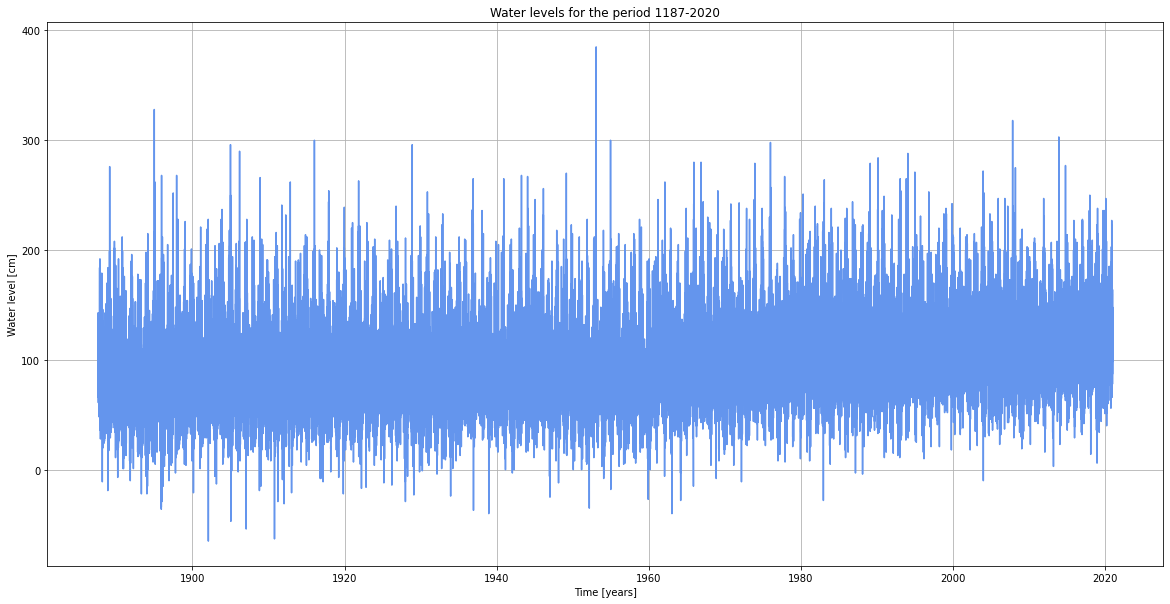

In [2]:
df = pd.read_csv(
    'Meetreeks_HVH.txt',
    delim_whitespace=True,
    header=None,
    names=['Date', 'Time', 'Value'])

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)

# Reorganize the DataFrame to have 'Datetime' as the first column
df = df[["Datetime", "Value"]]

plt.figure(figsize=(20,10))
plt.plot(df["Datetime"], df["Value"], color = 'cornflowerblue')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('Water levels for the period 1187-2020')
plt.grid()
plt.savefig('Complete_dataset.png')

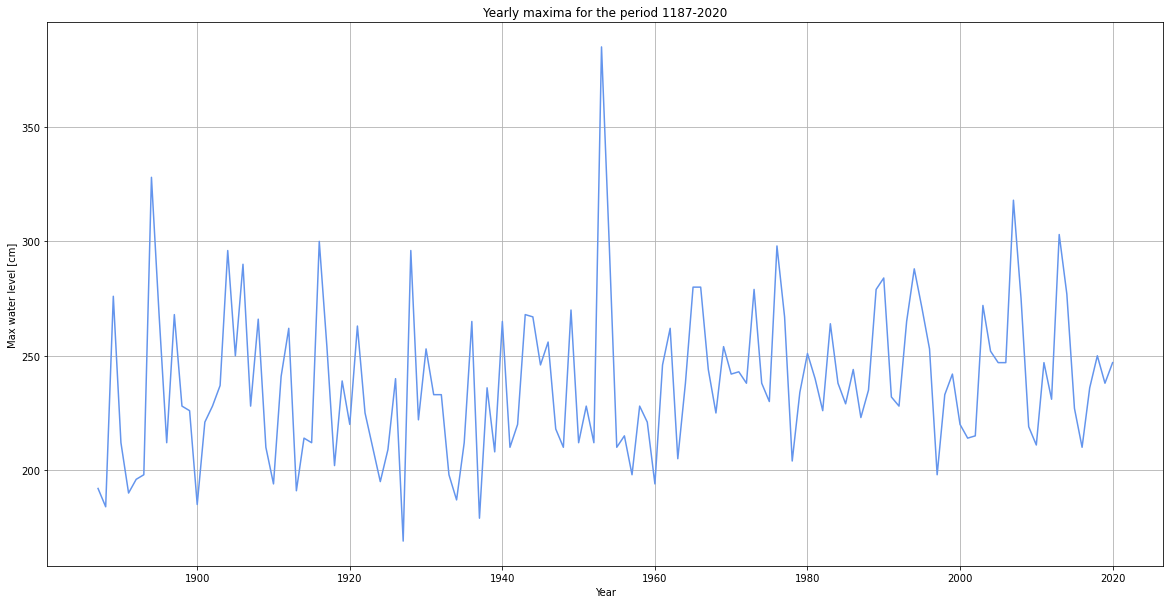

In [3]:
## Report yearly maxima for each year
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day

## Get maxima
df_yearly_max = df.groupby('Year').max()
df_yearly_max = df_yearly_max.reset_index()
df_yearly_max = df_yearly_max[['Year', 'Value']]
df_yearly_max.columns = ['Year', 'Max_value']

## Plot the yearly maxima
plt.figure(figsize=(20,10))
plt.plot(df_yearly_max['Year'], df_yearly_max['Max_value'], color = 'cornflowerblue')
plt.xlabel('Year')
plt.ylabel('Max water level [cm]')
plt.title('Yearly maxima for the period 1187-2020')
plt.grid()

**Additional explanation for the graph above:**
In the graph plotted above, the yearly maxima of waterlevels at Hoek van Holland are plotted. It can be observed that the maximum generally lie between 200-300 cm. At one instance, a very high peak was observed with a value of almost 400 cm. This point in time corresponds to the flood disaster of 1953, which flooded large parts of Zeeland and Zuid-Holland. 

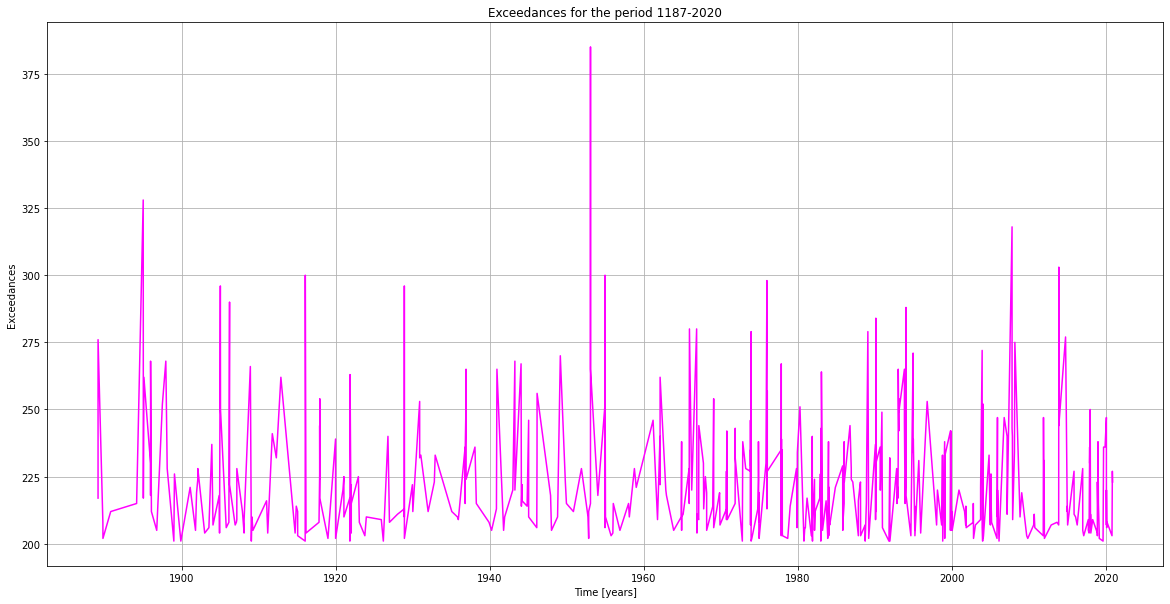

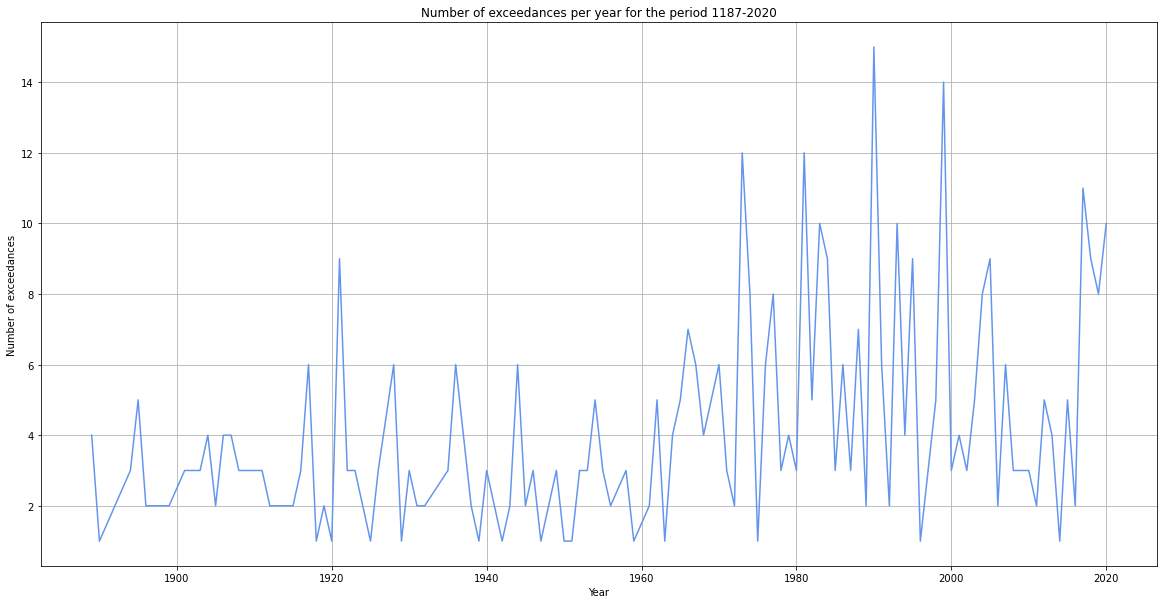

In [10]:
## Define the threshold
threshold = 200

## Get the exceedances
exceedances = df[df['Value'] > threshold]
exceedances = exceedances.reset_index()
exceedances = exceedances[['Datetime', 'Value']]
exceedances.columns = ['Datetime', 'Exceedance']

## Get the number of exceedances per year
exceedances['Year'] = exceedances['Datetime'].dt.year
exceedances_peryear = exceedances.groupby('Year').count()
exceedances_peryear = exceedances_peryear.reset_index()
exceedances_peryear = exceedances_peryear[['Year', 'Exceedance']]
exceedances_peryear.columns = ['Year', 'Exceedances']

## Plot exceedances
plt.figure(figsize=(20,10))
plt.plot(exceedances['Datetime'], exceedances['Exceedance'], color = 'magenta')
plt.xlabel('Time [years]')
plt.ylabel('Exceedances')
plt.title('Exceedances for the period 1187-2020')
plt.grid()


## Plot the number of exceedances per year
plt.figure(figsize=(20,10))
plt.plot(exceedances_peryear['Year'], exceedances_peryear['Exceedances'], color = 'cornflowerblue')
plt.xlabel('Year')
plt.ylabel('Number of exceedances')
plt.title('Number of exceedances per year for the period 1187-2020')
plt.grid()

**Additional explanation for the graph above:**
In the upper graph, Peak Over Threshold is used to obtain extreme values for the water levels at Hoek van Holland. In this plot it can already be observed that the frequency of the exceedences increases after 1970. This is also visible in the lower graph, where the number of exceedences per year is plotted. 

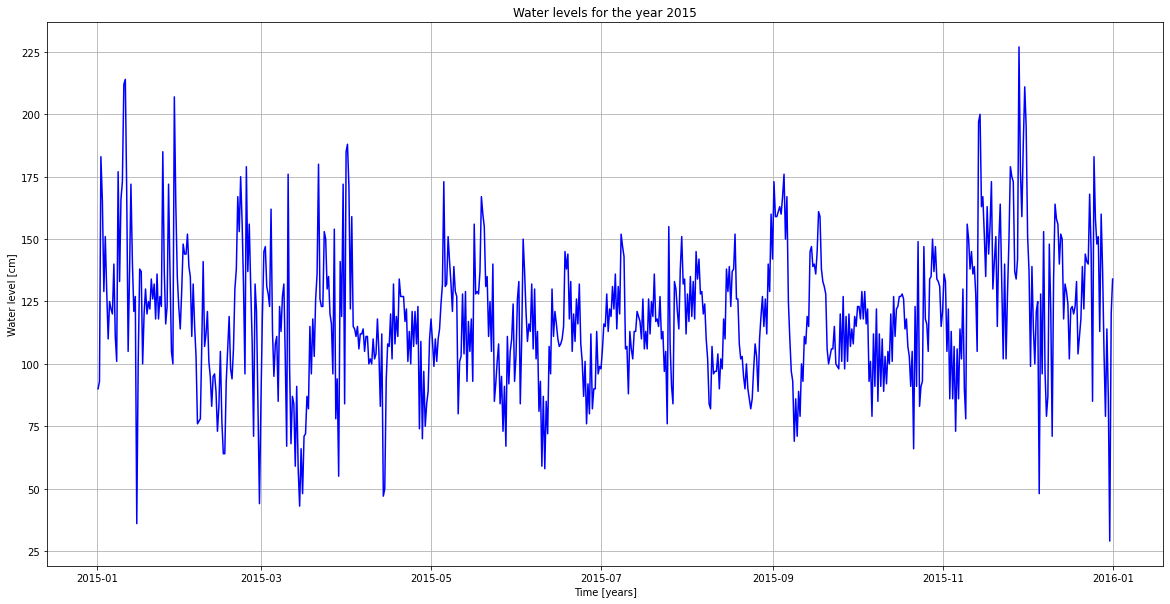

In [15]:
## Plot values for the year 2015
df_2015 = df[df['Year'] == 2015]
plt.figure(figsize=(20,10))
plt.plot(df_2015['Datetime'], df_2015['Value'], color = 'blue')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('Water levels for the year 2015')
plt.grid()